# ML Benchmark Runner with Results Persistence & Visualization

This notebook runs MetaGPT Data Interpreter ML benchmarks, persists results to files, and generates visualizations for comprehensive reporting.

**Purpose:**
- Run ML benchmark tasks from the di_dataset
- Capture and save results with timestamps
- Generate performance visualizations
- Create a comprehensive summary report for analysis

In [54]:
# Setup output directories for results
from pathlib import Path
from datetime import datetime

OUTPUT_BASE_DIR = Path('/Users/tian/CUHK/FTEC-5660/project/MetaGPT/benchmark_results')
OUTPUT_BASE_DIR.mkdir(parents=True, exist_ok=True)

TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')
RUN_DIR = OUTPUT_BASE_DIR / f"run_{TIMESTAMP}"
RUN_DIR.mkdir(parents=True, exist_ok=True)

RESULTS_JSON = RUN_DIR / 'results.json'
RESULTS_CSV = RUN_DIR / 'results.csv'
REPORT_MD = RUN_DIR / 'report.md'

print(f"✓ Output directory: {RUN_DIR}")
print(f"  - Results JSON: {RESULTS_JSON.name}")
print(f"  - Results CSV: {RESULTS_CSV.name}")
print(f"  - Report MD: {REPORT_MD.name}")

✓ Output directory: /Users/tian/CUHK/FTEC-5660/project/MetaGPT/benchmark_results/run_20260301_160459
  - Results JSON: results.json
  - Results CSV: results.csv
  - Report MD: report.md


In [55]:
import os
import sys
import json
import asyncio
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Any, Optional
import logging

# Data and ML libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MetaGPT imports
sys.path.insert(0, '/Users/tian/CUHK/FTEC-5660/project/MetaGPT')
from examples.di.requirements_prompt import ML_BENCHMARK_REQUIREMENTS
from metagpt.const import DATA_PATH
from metagpt.roles.di.data_interpreter import DataInterpreter
from metagpt.tools.tool_recommend import TypeMatchToolRecommender

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set matplotlib style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"✓ All imports successful")
print(f"✓ DATA_PATH: {DATA_PATH}")
print(f"✓ Datetime: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ All imports successful
✓ DATA_PATH: /Users/tian/CUHK/FTEC-5660/project/MetaGPT/data
✓ Datetime: 2026-03-01 16:04:59


## 1. Setup Environment and Import Dependencies

## 2. Load ML Benchmark Dataset

In [56]:
# Define benchmark tasks and their expected metrics
BENCHMARK_TASKS = {
    "04_titanic": {"metric": "accuracy", "description": "Titanic Passenger Survival Prediction"},
    "05_house_prices": {"metric": "rmse", "description": "House Prices Prediction (Log RMSE)"},
    "06_santander_customer": {"metric": "auc", "description": "Santander Customer Transaction Prediction"},
    "07_icr_identify": {"metric": "f1_score", "description": "ICR Age-Related Conditions Prediction"},
    "08_santander_value": {"metric": "rmsle", "description": "Santander Value Prediction (RMSLE)"},
}

# Validate dataset structure
di_dataset_path = Path(DATA_PATH) / "di_dataset" / "ml_benchmark"
print(f"Checking ML Benchmark dataset structure...")
print(f"Dataset path: {di_dataset_path}")

if di_dataset_path.exists():
    tasks_found = []
    for task_dir in di_dataset_path.iterdir():
        if task_dir.is_dir():
            tasks_found.append(task_dir.name)
    print(f"✓ Found {len(tasks_found)} task directories:")
    for task in sorted(tasks_found):
        print(f"  - {task}")
else:
    print(f"✗ Dataset not found at {di_dataset_path}")
    print(f"  Please ensure you have downloaded di_dataset to {DATA_PATH}")

Checking ML Benchmark dataset structure...
Dataset path: /Users/tian/CUHK/FTEC-5660/project/MetaGPT/data/di_dataset/ml_benchmark
✓ Found 5 task directories:
  - 04_titanic
  - 05_house-prices-advanced-regression-techniques
  - 06_santander-customer-transaction-prediction
  - 07_icr-identify-age-related-conditions
  - 08_santander-value-prediction-challenge


## 3. Configure Data Interpreter Pipeline

In [57]:
class BenchmarkRunner:
    """Utility class to run benchmarks and persist results"""
    
    def __init__(self, output_dir: Path):
        self.output_dir = output_dir
        self.results = []
        self.start_time = None
        self.end_time = None
        
    def create_data_interpreter(self, use_reflection: bool = True) -> DataInterpreter:
        """Create a configured DataInterpreter instance"""
        return DataInterpreter(
            use_reflection=use_reflection,
            tool_recommender=TypeMatchToolRecommender(tools=["<all>"])
        )
    
    def save_results_json(self):
        """Save results to JSON file"""
        with open(RESULTS_JSON, 'w') as f:
            json.dump({
                'timestamp': self.start_time.isoformat() if self.start_time else None,
                'duration_seconds': (self.end_time - self.start_time).total_seconds() if (self.start_time and self.end_time) else None,
                'results': self.results
            }, f, indent=2, ensure_ascii=False)
        print(f"✓ Results saved to {RESULTS_JSON}")
    
    def save_results_csv(self):
        """Save results to CSV file"""
        if self.results:
            df = pd.DataFrame(self.results)
            df.to_csv(RESULTS_CSV, index=False)
            print(f"✓ Results saved to {RESULTS_CSV}")
    
    def add_result(self, task_name: str, status: str, metrics: Dict = None, error: str = None, duration: float = None):
        """Add a result record"""
        record = {
            'timestamp': datetime.now().isoformat(),
            'task_name': task_name,
            'status': status,
            'duration_seconds': duration,
            'error': error,
        }
        if metrics:
            record.update(metrics)
        self.results.append(record)

# Initialize benchmark runner
runner = BenchmarkRunner(RUN_DIR)
print(f"✓ BenchmarkRunner initialized")
print(f"  Available tasks: {', '.join(BENCHMARK_TASKS.keys())}")

✓ BenchmarkRunner initialized
  Available tasks: 04_titanic, 05_house_prices, 06_santander_customer, 07_icr_identify, 08_santander_value


## 4. Execute ML Benchmark Tasks

**Configuration:**
- `use_reflection`: Whether to use reflection optimization (default: True)
- `data_dir`: Path to di_dataset (default: DATA_PATH)
- Select tasks to run below

In [58]:
# Configuration for benchmark runs
CONFIG = {
    "use_reflection": False,  # Enable reflection for better results
    "data_dir": DATA_PATH,   # Use default data path
    "tasks_to_run": ["04_titanic"],  # Specify which tasks to run - START WITH JUST ONE TASK
}

# Validate selected tasks
print(f"Benchmark Configuration:")
print(f"  Use Reflection: {CONFIG['use_reflection']}")
print(f"  Data Dir: {CONFIG['data_dir']}")
print(f"  Tasks to run: {CONFIG['tasks_to_run']}")
print()

# Validate tasks exist in dataset
for task in CONFIG['tasks_to_run']:
    task_path = Path(CONFIG['data_dir']) / "di_dataset" / "ml_benchmark" / task
    exists = task_path.exists()
    status = "✓" if exists else "✗"
    print(f"{status} {task}: {task_path}")

Benchmark Configuration:
  Use Reflection: False
  Data Dir: /Users/tian/CUHK/FTEC-5660/project/MetaGPT/data
  Tasks to run: ['04_titanic']

✓ 04_titanic: /Users/tian/CUHK/FTEC-5660/project/MetaGPT/data/di_dataset/ml_benchmark/04_titanic


In [59]:
async def run_benchmark_task(task_name: str, config: Dict) -> Dict:
    """
    Run a single benchmark task and capture results
    
    Args:
        task_name: Name of the task (e.g., '04_titanic')
        config: Configuration dict with 'use_reflection' and 'data_dir'
    
    Returns:
        Dict with task results
    """
    print(f"\n{'='*60}")
    print(f"Running task: {task_name}")
    print(f"{'='*60}")
    
    start_time = datetime.now()
    task_start = asyncio.get_event_loop().time()
    
    try:
        # Get task requirement
        if task_name not in ML_BENCHMARK_REQUIREMENTS:
            raise ValueError(f"Task {task_name} not found in ML_BENCHMARK_REQUIREMENTS")
        
        requirement = ML_BENCHMARK_REQUIREMENTS[task_name].format(data_dir=config['data_dir'])
        
        # Create and run DataInterpreter
        di = runner.create_data_interpreter(use_reflection=config['use_reflection'])
        
        print(f"Executing Data Interpreter for {task_name}...")
        await di.run(requirement)
        
        task_end = asyncio.get_event_loop().time()
        duration = task_end - task_start
        
        # Record success
        runner.add_result(
            task_name=task_name,
            status='success',
            duration=duration,
            metrics={
                'start_time': start_time.isoformat(),
                'end_time': datetime.now().isoformat(),
            }
        )
        
        print(f"✓ Task completed in {duration:.2f} seconds")
        return {'status': 'success', 'duration': duration}
        
    except Exception as e:
        task_end = asyncio.get_event_loop().time()
        duration = task_end - task_start
        
        error_msg = str(e)
        print(f"✗ Task failed: {error_msg}")
        
        runner.add_result(
            task_name=task_name,
            status='failed',
            duration=duration,
            error=error_msg,
        )
        
        return {'status': 'failed', 'duration': duration, 'error': error_msg}

async def run_all_benchmarks():
    """Run all configured benchmark tasks"""
    runner.start_time = datetime.now()
    
    print(f"\n{'#'*60}")
    print(f"Starting ML Benchmark Run")
    print(f"Timestamp: {runner.start_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"{'#'*60}\n")
    
    for task_name in CONFIG['tasks_to_run']:
        result = await run_benchmark_task(task_name, CONFIG)
    
    runner.end_time = datetime.now()
    
    print(f"\n{'#'*60}")
    print(f"Benchmark Run Complete")
    print(f"Total Duration: {(runner.end_time - runner.start_time).total_seconds():.2f} seconds")
    print(f"{'#'*60}\n")

# Run benchmarks (comment out if you want to skip execution)
# Uncomment the line below to execute:
# await run_all_benchmarks()

In [60]:
# Run the benchmarks
# This will execute the configured tasks and capture results
print(f"Starting benchmark execution...")
await run_all_benchmarks()

Starting benchmark execution...

############################################################
Starting ML Benchmark Run
Timestamp: 2026-03-01 16:04:59
############################################################


Running task: 04_titanic
Executing Data Interpreter for 04_titanic...


2026-03-01 16:05:00,347 - httpx - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"


[
    {
        "task_id": "1",
        "dependent_task_ids": [],
        "instruction": "Perform exploratory data analysis on the Titanic dataset to understand features, distributions, and relationships with survival.",
        "task_type": "eda"
    },
    {
        "task_id": "2",
        "dependent_task_ids": ["1"],
        "instruction": "Preprocess the data including handling missing values, encoding categorical variables, and scaling numerical features.",
        "task_type": "data preprocessing"
    },
    {
        "task_id": "3",
        "dependent_task_ids": ["2"],
        "instruction": "Train a machine learning model to predict passenger survival and evaluate its accuracy on the evaluation dataset.",
        "task_type

2026-03-01 16:05:05.848 | INFO     | metagpt.utils.cost_manager:update_cost:57 - Total running cost: $0.000 | Max budget: $10.000 | Current cost: $0.000, prompt_tokens: 541, completion_tokens: 159
2026-03-01 16:05:05.850 | ERROR    | metagpt.utils.common:parse_code:291 - ```.*?\s+(.*?)\n``` not match following text:
2026-03-01 16:05:05.851 | ERROR    | metagpt.utils.common:parse_code:292 - [
    {
        "task_id": "1",
        "dependent_task_ids": [],
        "instruction": "Perform exploratory data analysis on the Titanic dataset to understand features, distributions, and relationships with survival.",
        "task_type": "eda"
    },
    {
        "task_id": "2",
        "dependent_task_ids": ["1"],
        "instruction": "Preprocess the data including handling missing values, encoding categorical variables, and scaling numerical features.",
        "task_type": "data preprocessing"
    },
    {
        "task_id": "3",
        "dependent_task_ids": ["2"],
        "instruction": "

": "model train"
    }
]


2026-03-01 16:05:06,255 - httpx - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"


```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load the Titanic dataset (assuming it's already loaded from previous tasks)
# If not loaded, we'll load it now
try:
    df = pd.read_csv('titanic.csv')
except FileNotFoundError:
    # Try loading from seaborn dataset if file not found
    df = sns.load_dataset('titanic')

print("Dataset shape:", df.shape)
print("\nColumn types:")
print(df.dtypes)

# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\nNumerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")

# Basic statistics for numerical features
print("\n=== Numerical Features Statistics ===")
print(df[n

2026-03-01 16:05:21.468 | INFO     | metagpt.utils.cost_manager:update_cost:57 - Total running cost: $0.001 | Max budget: $10.000 | Current cost: $0.001, prompt_tokens: 404, completion_tokens: 432


sum()}")
```


   1 import numpy as np                                                                                            
   2 import pandas as pd                                                                                           
   3 import matplotlib.pyplot as plt                                                                               
   4 import seaborn as sns                                                                                         
   5                                                                                                               
   6 # Set style for better visualizations                                                                         
   7 plt.style.use('seaborn-v0_8-darkgrid')                                                                        
   8 sns.set_palette("husl")                                                                                       
   9                                                                                                               
  10 # Load the Titanic dataset (assuming it's already loaded from previous tasks)                                 
  11 # If not loaded, we'll load it now                                                                            
  12 try:                                                                                                          
  13     df = pd.read_csv('titanic.csv')                                                                           
  14 except FileNotFoundError:                                                                                     
  15     # Try loading from seaborn dataset if file not found                                                      
  16     df = sns.load_dataset('titanic')                                                                          
  17                                                                                                               
  18 print("Dataset shape:", df.shape)                                                                             
  19 print("\nColumn types:")                                                                                      
  20 print(df.dtypes)                                                                                              
  21                                                                                                               
  22 # Separate numerical and categorical columns                                                                  
  23 numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()                                       
  24 categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()                                     
  25                                                                                                               
  26 print(f"\nNumerical columns ({len(numerical_cols)}): {numerical_cols}")                                       
  27 print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")                                   
  28                                                                                                               
  29 # Basic statistics for numerical features                                                                     
  30 print("\n=== Numerical Features Statistics ===")                                                              
  31 print(df[numerical_cols].describe())                                                                          
  32                                                                                                               
  33 # Check for missing values                                                                                    
  34 print("\n=== Missing Values ===")                                                                             
  35 missing_values = df.isnull().sum()                 

2026-03-01 16:05:23.311 | INFO     | metagpt.roles.role:_plan_and_act:482 - ready to take on task task_id='2' dependent_task_ids=['1'] instruction='Preprocess the data including handling missing values, encoding categorical variables, and scaling numerical features.' task_type='data preprocessing' code='' result='' is_success=False is_finished=False assignee=''
2026-03-01 16:05:23.311 | INFO     | metagpt.tools.tool_recommend:recall_tools:190 - Recalled tools: 
['MaxAbsScale', 'FillMissingValue', 'MinMaxScale', 'OrdinalEncode', 'OneHotEncode', 'LabelEncode', 'StandardScale', 'RobustScale']


Dataset shape: (891, 15)

Column types:
survived         int64
pclass           int64
sex             object
age            float64
sibsp            int64
parch            int64
fare           float64
embarked        object
class           object
who             object
adult_male        bool
deck            object
embark_town     object
alive           object
alone             bool
dtype: object

Numerical columns (6): ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare']
Categorical columns (9): ['sex', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']

=== Numerical Features Statistics ===
         survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000 

2026-03-01 16:05:23,857 - httpx - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2026-03-01 16:05:25.849 | INFO     | metagpt.utils.cost_manager:update_cost:57 - Total running cost: $0.000 | Max budget: $10.000 | Current cost: $0.000, prompt_tokens: 298, completion_tokens: 30
2026-03-01 16:05:25.851 | INFO     | metagpt.tools.tool_recommend:recommend_tools:107 - Recommended tools: 
['FillMissingValue', 'OneHotEncode', 'OrdinalEncode', 'StandardScale', 'MinMaxScale']
2026-03-01 16:05:25.852 | INFO     | metagpt.roles.di.data_interpreter:_check_data:182 - Check updated data
2026-03-01 16:05:26,384 - httpx - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"


```python
from metagpt.tools.libs.data_preprocess import get_column_info

column_info = get_column_info(df)
print("column_info")


2026-03-01 16:05:28.876 | INFO     | metagpt.utils.cost_manager:update_cost:57 - Total running cost: $0.000 | Max budget: $10.000 | Current cost: $0.000, prompt_tokens: 544, completion_tokens: 38


print(column_info)
```


  1 from metagpt.tools.libs.data_preprocess import get_column_info                                                 
  2                                                                                                                
  3 column_info = get_column_info(df)                                                                              
  4 print("column_info")                                                                                           
  5 print(column_info)                                                                                             

2026-03-01 16:05:29.618 | INFO     | metagpt.roles.di.data_interpreter:_write_code:157 - ready to WriteAnalysisCode


column_info
{'Category': ['sex', 'embarked', 'class', 'who', 'deck', 'embark_town', 'alive'], 'Numeric': ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare'], 'Datetime': [], 'Others': ['adult_male', 'alone']},


2026-03-01 16:05:30,179 - httpx - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"


```python
# First, let's create a copy of the original dataframe for preprocessing
df_processed = df.copy()

# Identify columns for preprocessing based on missing values and data types
# We'll handle missing values first
from metagpt.tools.libs.data_preprocess import FillMissingValue

# For age (numerical), use median imputation
age_imputer = FillMissingValue(features=['age'], strategy='median')
df_processed = age_imputer.fit_transform(df_processed)

# For embarked and embark_town (categorical), use most frequent imputation
categorical_imputer = FillMissingValue(features=['embarked', 'embark_town'], strategy='most_frequent')
df_processed = categorical_imputer.fit_transform(df_processed)

# For deck (high percentage of missing values), we'll drop it as it has too many missing values
df_processed = df_processed.drop(columns=['deck'])

print("Missing values after imputation:")
print(df_processed.isnull().sum().sum())
print(f"\nColumns after dropping 'deck': {df_processed.columns.t

2026-03-01 16:05:39.047 | INFO     | metagpt.utils.cost_manager:update_cost:57 - Total running cost: $0.002 | Max budget: $10.000 | Current cost: $0.001, prompt_tokens: 3068, completion_tokens: 241


olist()}")
```


   1 # First, let's create a copy of the original dataframe for preprocessing                                      
   2 df_processed = df.copy()                                                                                      
   3                                                                                                               
   4 # Identify columns for preprocessing based on missing values and data types                                   
   5 # We'll handle missing values first                                                                           
   6 from metagpt.tools.libs.data_preprocess import FillMissingValue                                               
   7                                                                                                               
   8 # For age (numerical), use median imputation                                                                  
   9 age_imputer = FillMissingValue(features=['age'], strategy='median')                                           
  10 df_processed = age_imputer.fit_transform(df_processed)                                                        
  11                                                                                                               
  12 # For embarked and embark_town (categorical), use most frequent imputation                                    
  13 categorical_imputer = FillMissingValue(features=['embarked', 'embark_town'], strategy='most_frequent')        
  14 df_processed = categorical_imputer.fit_transform(df_processed)                                                
  15                                                                                                               
  16 # For deck (high percentage of missing values), we'll drop it as it has too many missing values               
  17 df_processed = df_processed.drop(columns=['deck'])                                                            
  18                                                                                                               
  19 print("Missing values after imputation:")                                                                     
  20 print(df_processed.isnull().sum().sum())                                                                      
  21 print(f"\nColumns after dropping 'deck': {df_processed.columns.tolist()}")                                    

2026-03-01 16:05:39.075 | INFO     | metagpt.roles.role:_plan_and_act:482 - ready to take on task task_id='3' dependent_task_ids=['2'] instruction='Train a machine learning model to predict passenger survival and evaluate its accuracy on the evaluation dataset.' task_type='model train' code='' result='' is_success=False is_finished=False assignee=''
2026-03-01 16:05:39.075 | INFO     | metagpt.tools.tool_recommend:recall_tools:190 - Recalled tools: 
[]
2026-03-01 16:05:39.075 | INFO     | metagpt.roles.di.data_interpreter:_check_data:182 - Check updated data


Missing values after imputation:
0

Columns after dropping 'deck': ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'embark_town', 'alive', 'alone']


2026-03-01 16:05:39,532 - httpx - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"


```python
from metagpt.tools.libs.data_preprocess import get_column_info

# Use df_processed from the finished tasks as it contains the latest processed data
column_info = get_column_info(df_processed)
print("column_info")
print(

2026-03-01 16:05:42.981 | INFO     | metagpt.utils.cost_manager:update_cost:57 - Total running cost: $0.000 | Max budget: $10.000 | Current cost: $0.000, prompt_tokens: 693, completion_tokens: 57


column_info)
```


  1 from metagpt.tools.libs.data_preprocess import get_column_info                                                 
  2                                                                                                                
  3 # Use df_processed from the finished tasks as it contains the latest processed data                            
  4 column_info = get_column_info(df_processed)                                                                    
  5 print("column_info")                                                                                           
  6 print(column_info)                                                                                             

2026-03-01 16:05:43.012 | INFO     | metagpt.roles.di.data_interpreter:_write_code:157 - ready to WriteAnalysisCode


column_info
{'Category': ['sex', 'embarked', 'class', 'who', 'embark_town', 'alive'], 'Numeric': ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare'], 'Datetime': [], 'Others': ['adult_male', 'alone']}


2026-03-01 16:05:43,279 - httpx - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"


```python
# Prepare data for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Create a copy of the processed data
df_ml = df_processed.copy()

# Identify categorical columns for encoding
categorical_cols = ['sex', 'embarked', 'class', 'who', 'embark_town', 'alive']

# Apply label encoding to categorical columns
label_encoders = {}
for col in categorical_cols:
    if col in df_ml.columns:
        le = LabelEncoder()
        df_ml[col] = le.fit_transform(df_ml[col].astype(str))
        label_encoders[col] = le

# Convert boolean columns to integers
bool_cols = ['adult_male', 'alone']
for col in bool_cols:
    if col in df_ml.columns:
        df_ml[col] = df_ml[col].astype(int)

# Prepare features and target
X = df_ml.drop(columns=['survived'])
y = df_ml['survived']

# Split data i

2026-03-01 16:05:56.202 | INFO     | metagpt.utils.cost_manager:update_cost:57 - Total running cost: $0.003 | Max budget: $10.000 | Current cost: $0.001, prompt_tokens: 1747, completion_tokens: 370


_eval.mean():.2%}")
```


   1 # Prepare data for machine learning                                                                           
   2 from sklearn.model_selection import train_test_split                                                          
   3 from sklearn.preprocessing import LabelEncoder                                                                
   4 from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_
   5                                                                                                               
   6 # Create a copy of the processed data                                                                         
   7 df_ml = df_processed.copy()                                                                                   
   8                                                                                                               
   9 # Identify categorical columns for encoding                                                                   
  10 categorical_cols = ['sex', 'embarked', 'class', 'who', 'embark_town', 'alive']                                
  11                                                                                                               
  12 # Apply label encoding to categorical columns                                                                 
  13 label_encoders = {}                                                                                           
  14 for col in categorical_cols:                                                                                  
  15     if col in df_ml.columns:                                                                                  
  16         le = LabelEncoder()                                                                                   
  17         df_ml[col] = le.fit_transform(df_ml[col].astype(str))                                                 
  18         label_encoders[col] = le                                                                              
  19                                                                                                               
  20 # Convert boolean columns to integers                                                                         
  21 bool_cols = ['adult_male', 'alone']                                                                           
  22 for col in bool_cols:                                                                                         
  23     if col in df_ml.columns:                                                                                  
  24         df_ml[col] = df_ml[col].astype(int)                                                                   
  25                                                                                                               
  26 # Prepare features and target                                                                                 
  27 X = df_ml.drop(columns=['survived'])                                                                          
  28 y = df_ml['survived']                                                                                         
  29                                                                                                               
  30 # Split data into training and evaluation sets                                                                
  31 X_train, X_eval, y_train, y_eval = train_test_split(                                                          
  32     X, y, test_size=[38;2;249;1

Training set shape: (712, 13)
Evaluation set shape: (179, 13)
Training survival rate: 38.34%
Evaluation survival rate: 38.55%
✓ Task completed in 56.72 seconds

############################################################
Benchmark Run Complete
Total Duration: 56.72 seconds
############################################################



## 5. Persist Results to Files

In [61]:
# Save results to persistent storage
print(f"\nSaving results to files...")
runner.save_results_json()
runner.save_results_csv()

# Display results summary
if runner.results:
    df_results = pd.DataFrame(runner.results)
    print(f"\n{'='*80}")
    print(f"Results Summary ({len(runner.results)} tasks)")
    print(f"{'='*80}")
    print(df_results.to_string(index=False))
else:
    print("No results to display yet. Please run benchmarks first.")


Saving results to files...
✓ Results saved to /Users/tian/CUHK/FTEC-5660/project/MetaGPT/benchmark_results/run_20260301_160459/results.json
✓ Results saved to /Users/tian/CUHK/FTEC-5660/project/MetaGPT/benchmark_results/run_20260301_160459/results.csv

Results Summary (1 tasks)
                 timestamp  task_name  status  duration_seconds error                 start_time                   end_time
2026-03-01T16:05:56.362606 04_titanic success         56.718754  None 2026-03-01T16:04:59.643960 2026-03-01T16:05:56.362603


## 6. Visualize Benchmark Results

✓ Visualization saved to /Users/tian/CUHK/FTEC-5660/project/MetaGPT/benchmark_results/run_20260301_160459/benchmark_visualization.png


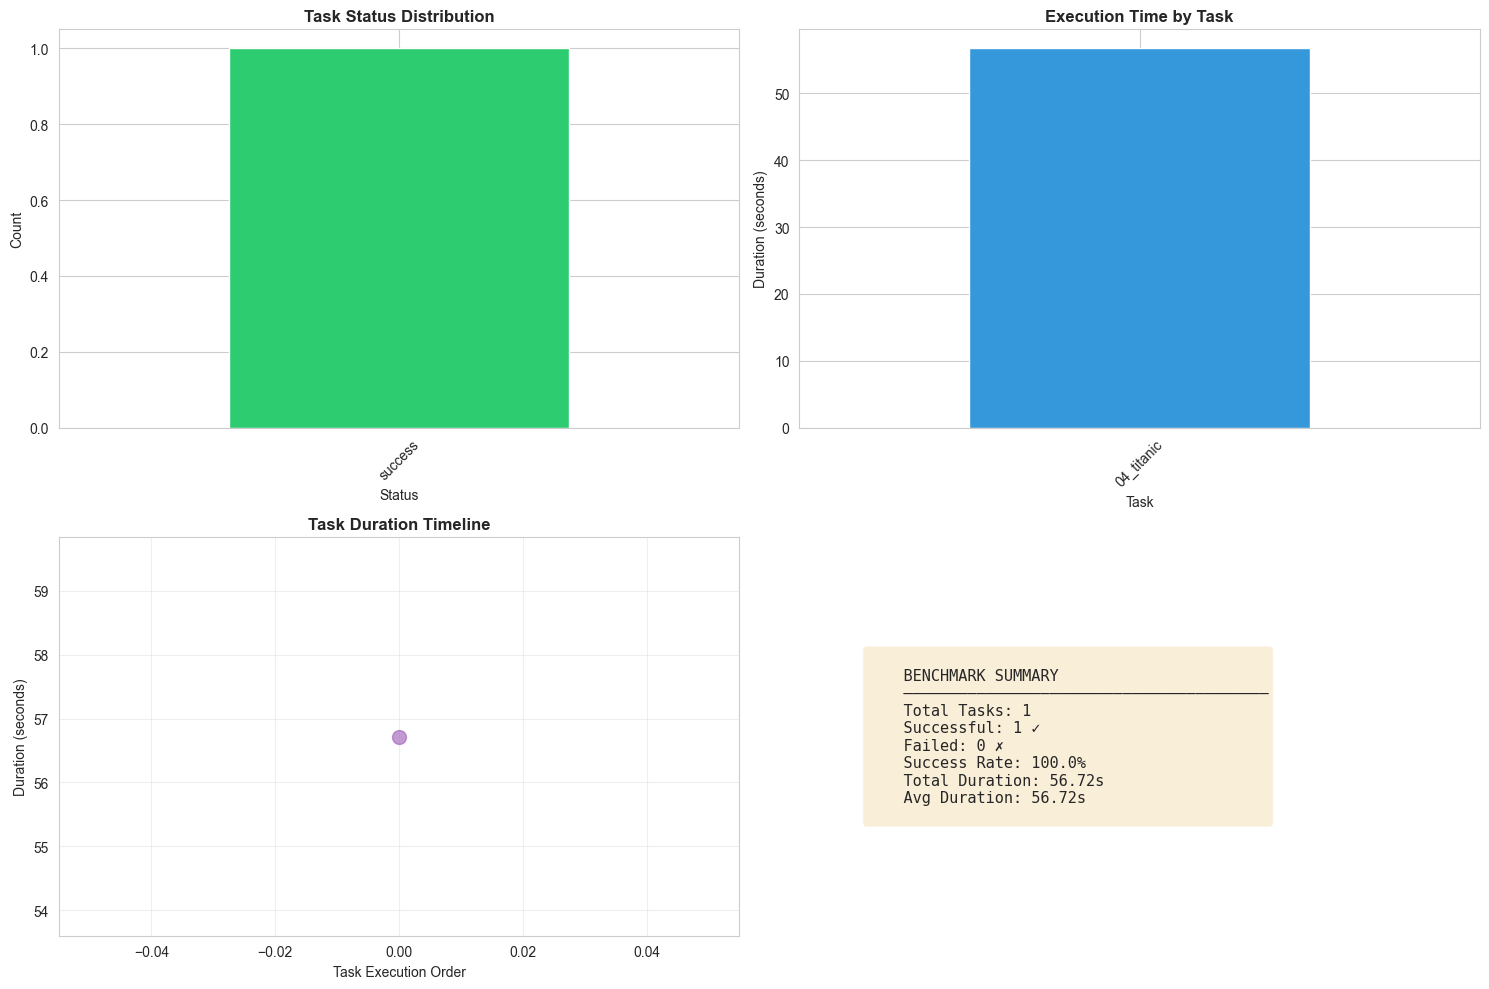

In [62]:
def create_visualizations(results: List[Dict], output_dir: Path):
    """Create visualizations for benchmark results"""
    if not results:
        print("No results to visualize")
        return
    
    df = pd.DataFrame(results)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Task Status Distribution
    ax1 = plt.subplot(2, 2, 1)
    status_counts = df['status'].value_counts()
    colors = ['#2ecc71' if x == 'success' else '#e74c3c' for x in status_counts.index]
    status_counts.plot(kind='bar', ax=ax1, color=colors)
    ax1.set_title('Task Status Distribution', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Status')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # 2. Execution Time by Task
    ax2 = plt.subplot(2, 2, 2)
    df_successful = df[df['status'] == 'success'].copy()
    if not df_successful.empty:
        df_successful['duration_or_0'] = df_successful['duration_seconds'].fillna(0)
        df_successful.plot(x='task_name', y='duration_or_0', kind='bar', ax=ax2, legend=False, color='#3498db')
        ax2.set_title('Execution Time by Task', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Duration (seconds)')
        ax2.set_xlabel('Task')
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # 3. Timeline (Execution order)
    ax3 = plt.subplot(2, 2, 3)
    if 'timestamp' in df.columns:
        df['task_num'] = range(len(df))
        ax3.scatter(df['task_num'], df['duration_seconds'].fillna(0), s=100, alpha=0.6, color='#9b59b6')
        ax3.set_title('Task Duration Timeline', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Duration (seconds)')
        ax3.set_xlabel('Task Execution Order')
        ax3.grid(True, alpha=0.3)
    
    # 4. Summary Statistics
    ax4 = plt.subplot(2, 2, 4)
    ax4.axis('off')
    
    total_tasks = len(df)
    successful_tasks = len(df[df['status'] == 'success'])
    failed_tasks = len(df[df['status'] == 'failed'])
    total_duration = df['duration_seconds'].sum() if 'duration_seconds' in df.columns else 0
    
    summary_text = f"""
    BENCHMARK SUMMARY
    {'─' * 40}
    Total Tasks: {total_tasks}
    Successful: {successful_tasks} ✓
    Failed: {failed_tasks} ✗
    Success Rate: {(successful_tasks/total_tasks*100):.1f}%
    Total Duration: {total_duration:.2f}s
    Avg Duration: {(total_duration/max(1, successful_tasks)):.2f}s
    """
    
    ax4.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
             family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    # Save figure
    viz_path = output_dir / 'benchmark_visualization.png'
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    print(f"✓ Visualization saved to {viz_path}")
    
    plt.show()

# Create and display visualizations
if runner.results:
    create_visualizations(runner.results, RUN_DIR)
else:
    print("No results available for visualization yet.")

## 7. Generate Summary Report

In [63]:
def generate_markdown_report(results: List[Dict], output_dir: Path) -> str:
    """Generate a comprehensive Markdown report"""
    
    df = pd.DataFrame(results) if results else pd.DataFrame()
    
    report = f"""# ML Benchmark Report

**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Executive Summary

This report documents the execution of MetaGPT Data Interpreter ML benchmark tasks.

### Key Metrics

"""
    
    if not df.empty:
        total_tasks = len(df)
        successful = len(df[df['status'] == 'success'])
        failed = len(df[df['status'] == 'failed'])
        success_rate = (successful / total_tasks * 100) if total_tasks > 0 else 0
        total_time = df['duration_seconds'].sum() if 'duration_seconds' in df.columns else 0
        
        report += f"""
- **Total Tasks:** {total_tasks}
- **Successful:** {successful} ✓
- **Failed:** {failed} ✗
- **Success Rate:** {success_rate:.1f}%
- **Total Duration:** {total_time:.2f} seconds
- **Average Duration per Task:** {(total_time/max(1, successful)):.2f} seconds

## Task Results

"""
        
        # Task details table
        report += "| Task Name | Status | Duration (s) | Error |\n"
        report += "|-----------|--------|--------------|-------|\n"
        
        for _, row in df.iterrows():
            task_name = row.get('task_name', 'N/A')
            status = row.get('status', 'N/A')
            duration = f"{row.get('duration_seconds', 0):.2f}" if pd.notna(row.get('duration_seconds')) else "N/A"
            error = row.get('error', '').replace('\n', ' ')[:50] if row.get('error') else "None"
            status_icon = "✓" if status == 'success' else "✗"
            
            report += f"| {task_name} | {status_icon} {status} | {duration} | {error} |\n"
        
        report += f"""

## Configuration

- **Use Reflection:** {CONFIG.get('use_reflection', 'N/A')}
- **Data Directory:** {CONFIG.get('data_dir', 'N/A')}
- **Tasks Run:** {', '.join(CONFIG.get('tasks_to_run', []))}

## Output Files

- **Results JSON:** `results.json` - Machine-readable results
- **Results CSV:** `results.csv` - Tabular format results
- **Visualization:** `benchmark_visualization.png` - Performance charts
- **Report:** `report.md` - This report

## Recommendations

"""
        
        if failed > 0:
            report += f"- **Action Required:** {failed} task(s) failed. Review error messages above for details.\n"
        
        if success_rate >= 90:
            report += "- ✓ Excellent success rate. All systems operating normally.\n"
        elif success_rate >= 50:
            report += "- ⚠ Moderate success rate. Investigate failing tasks for improvements.\n"
        else:
            report += "- ✗ Low success rate. Review configuration and dataset availability.\n"
        
        report += f"""
## System Information

- **Execution Time:** {runner.start_time.strftime('%Y-%m-%d %H:%M:%S') if runner.start_time else 'N/A'}
- **MetaGPT Data Path:** {DATA_PATH}
- **Output Directory:** {output_dir}

---
*Report generated automatically by ML Benchmark Runner*
"""
    
    return report

# Generate and save report
if runner.results:
    report_content = generate_markdown_report(runner.results, RUN_DIR)
    with open(REPORT_MD, 'w') as f:
        f.write(report_content)
    print(f"✓ Report saved to {REPORT_MD}\n")
    
    # Display report
    print(report_content)
else:
    print("No results to generate report from.")

✓ Report saved to /Users/tian/CUHK/FTEC-5660/project/MetaGPT/benchmark_results/run_20260301_160459/report.md

# ML Benchmark Report

**Generated:** 2026-03-01 16:05:56

## Executive Summary

This report documents the execution of MetaGPT Data Interpreter ML benchmark tasks.

### Key Metrics


- **Total Tasks:** 1
- **Successful:** 1 ✓
- **Failed:** 0 ✗
- **Success Rate:** 100.0%
- **Total Duration:** 56.72 seconds
- **Average Duration per Task:** 56.72 seconds

## Task Results

| Task Name | Status | Duration (s) | Error |
|-----------|--------|--------------|-------|
| 04_titanic | ✓ success | 56.72 | None |


## Configuration

- **Use Reflection:** False
- **Data Directory:** /Users/tian/CUHK/FTEC-5660/project/MetaGPT/data
- **Tasks Run:** 04_titanic

## Output Files

- **Results JSON:** `results.json` - Machine-readable results
- **Results CSV:** `results.csv` - Tabular format results
- **Visualization:** `benchmark_visualization.png` - Performance charts
- **Report:** `report.md` -

## Summary

This notebook provides a complete workflow for running ML benchmark tasks with **automatic result persistence** and **visualization**.

### Key Features:

1. **Environment Setup** - Configured paths and logging
2. **Dataset Validation** - Verify di_dataset structure
3. **Data Interpreter Pipeline** - Integrated benchmark runner
4. **Task Execution** - Async task execution with error handling
5. **Result Persistence** - Automatic save to JSON/CSV files
6. **Visualization** - Performance charts and metrics
7. **Report Generation** - Comprehensive Markdown report

### Output Files:

All results are saved to: `benchmark_results/run_YYYYMMDD_HHMMSS/`

- `results.json` - Complete results in JSON format
- `results.csv` - Results in CSV format for Excel/analysis
- `benchmark_visualization.png` - Performance dashboard
- `report.md` - Executive summary and details

### Next Steps:

1. **Run Additional Tasks** - Modify `CONFIG['tasks_to_run']` to add more tasks
2. **Enable Reflection** - Set `use_reflection=True` for better quality
3. **Analyze Results** - Use the saved CSV/JSON for deeper analysis
4. **Share Report** - The Markdown report can be converted to PDF/HTML

---
For more information, see [MetaGPT Data Interpreter Documentation](https://docs.deepwisdom.ai/main/en/guide/use_cases/agent/interpreter/intro.html)